# Part 3.2

Apply the solution in mitigating the influence of OOV words (from part 1) and train your model again

In [1]:
from datasets import load_dataset
from utils.rnn_model import *
from utils.rnn_utils import *
from utils.utils import *
from dotenv import load_dotenv
import os

load_dotenv()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Data Preparation

In [2]:
BATCH_SIZE = 32
LR = 0.0001
MODEL_TYPE = "rnn"

In [3]:
dataset = load_dataset("rotten_tomatoes")
trn_dataset = dataset["train"]
val_dataset = dataset["validation"]
tst_dataset = dataset["test"]

In [4]:
sentences = trn_dataset["text"]
words = []

for i in range(len(sentences)):
    sentences[i] = simple_preprocess(sentences[i])

for sentence in sentences:
    for word in sentence:
        if word not in words:
            words.append(word)

# load the processed embedding matrix from Part 1
word2vec_model = load_word2vec(vocab=words, filepath=r"data\embedding_matrix_non_oov.npy")

In [5]:
word_index = {
    word: i for i, word in enumerate(
        word2vec_model.index_to_key
    )
}

In [6]:
trn_sentences, trn_labels = prepare_data(
    trn_dataset["text"],
    trn_dataset["label"],
    word_index=word_index
)
val_sentences, val_labels = prepare_data(
    val_dataset["text"],
    val_dataset["label"],
    word_index=word_index
)
tst_sentences, tst_labels = prepare_data(
    tst_dataset["text"],
    tst_dataset["label"],
    word_index=word_index
)

In [7]:
trn_dataloader = create_dataloader(
    trn_sentences,
    trn_labels,
    BATCH_SIZE,
    shuffle=True)
val_dataloader = create_dataloader(
    val_sentences,
    val_labels,
    BATCH_SIZE,
    shuffle=False)
tst_dataloader = create_dataloader(
    tst_sentences,
    tst_labels,
    BATCH_SIZE,
    shuffle=False)

# Models

## Default RNN Model

In [8]:
model = RNNModel(
    embedding_dim=350,
    hidden_size=128,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,
    freeze_embeddings=False,  # Set to False to make embeddings trainable
    bidirectional=False,
    num_layers=1,
)

In [9]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode=None
)

Epoch   1/100, Loss: 0.6953, Accuracy: 0.5122
Model saved.
Epoch   2/100, Loss: 0.6885, Accuracy: 0.5178
Model saved.
Epoch   3/100, Loss: 0.6292, Accuracy: 0.7017
Model saved.
Epoch   4/100, Loss: 0.4127, Accuracy: 0.7336
Model saved.
Epoch   5/100, Loss: 0.2581, Accuracy: 0.7158
Epoch   6/100, Loss: 0.1759, Accuracy: 0.7195
Epoch   7/100, Loss: 0.1224, Accuracy: 0.6989
Epoch   8/100, Loss: 0.0900, Accuracy: 0.7101
Epoch   9/100, Loss: 0.0666, Accuracy: 0.6942
Epoch  10/100, Loss: 0.0547, Accuracy: 0.7139
Epoch  11/100, Loss: 0.0380, Accuracy: 0.7026
Epoch  12/100, Loss: 0.0291, Accuracy: 0.7054
Epoch  13/100, Loss: 0.0282, Accuracy: 0.7045
Epoch  14/100, Loss: 0.0183, Accuracy: 0.6886
Early stopping triggered after 14 epochs.
Training ended, loading best model...
Model loaded.


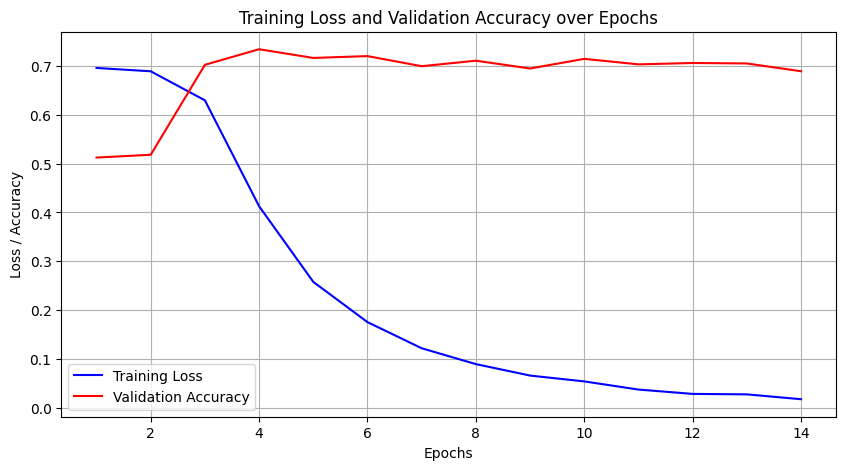

In [10]:
plot_loss_accuracy(losses, accuracies)

In [11]:
rnn_tst_accuracy = validate(model, tst_dataloader)

Accuracy: 0.7514


## Last State Model

In [12]:
model = RNNModel(
    embedding_dim=350,
    hidden_size=128,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,
    freeze_embeddings=False,  # Set to False to make embeddings trainable
    bidirectional=False,
    num_layers=1,
)

In [13]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="last_state"
)

Epoch   1/100, Loss: 0.6956, Accuracy: 0.5056
Model saved.
Epoch   2/100, Loss: 0.6898, Accuracy: 0.5216
Model saved.
Epoch   3/100, Loss: 0.6644, Accuracy: 0.6726
Model saved.
Epoch   4/100, Loss: 0.4679, Accuracy: 0.7289
Model saved.
Epoch   5/100, Loss: 0.2874, Accuracy: 0.7139
Epoch   6/100, Loss: 0.1911, Accuracy: 0.6904
Epoch   7/100, Loss: 0.1374, Accuracy: 0.7073
Epoch   8/100, Loss: 0.0955, Accuracy: 0.7008
Epoch   9/100, Loss: 0.0689, Accuracy: 0.7054
Epoch  10/100, Loss: 0.0517, Accuracy: 0.6979
Epoch  11/100, Loss: 0.0389, Accuracy: 0.7017
Epoch  12/100, Loss: 0.0326, Accuracy: 0.7036
Epoch  13/100, Loss: 0.0298, Accuracy: 0.6886
Epoch  14/100, Loss: 0.0195, Accuracy: 0.6970
Early stopping triggered after 14 epochs.
Training ended, loading best model...
Model loaded.


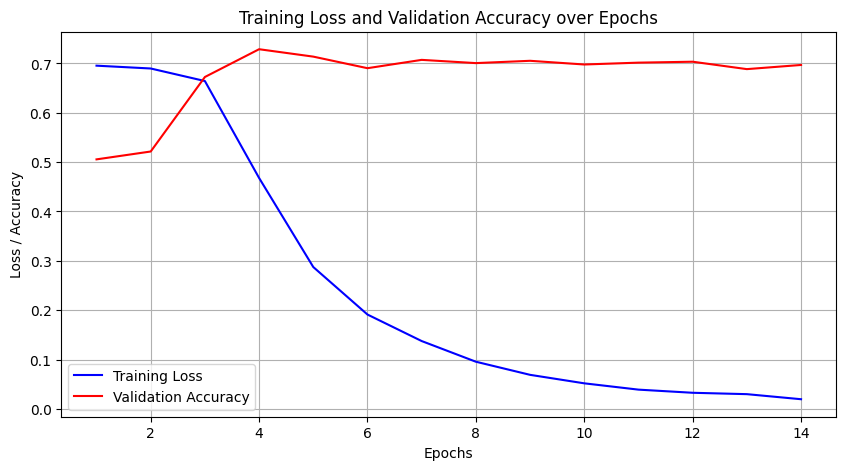

In [14]:
plot_loss_accuracy(losses, accuracies)

In [15]:
last_tst_accuracy = validate(model, tst_dataloader)

Accuracy: 0.7514


## Mean Pool Model

In [16]:
model = RNNModel(
    embedding_dim=350,
    hidden_size=128,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,
    freeze_embeddings=False,  # Set to False to make embeddings trainable
    bidirectional=False,
    num_layers=1,
)

In [17]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="mean_pooling"
)

Epoch   1/100, Loss: 0.6974, Accuracy: 0.5056
Model saved.
Epoch   2/100, Loss: 0.6912, Accuracy: 0.5272
Model saved.
Epoch   3/100, Loss: 0.6781, Accuracy: 0.5507
Model saved.
Epoch   4/100, Loss: 0.5730, Accuracy: 0.7101
Model saved.
Epoch   5/100, Loss: 0.3404, Accuracy: 0.7280
Model saved.
Epoch   6/100, Loss: 0.2079, Accuracy: 0.7214
Epoch   7/100, Loss: 0.1342, Accuracy: 0.7176
Epoch   8/100, Loss: 0.0858, Accuracy: 0.7233
Epoch   9/100, Loss: 0.0628, Accuracy: 0.7270
Epoch  10/100, Loss: 0.0401, Accuracy: 0.7223
Epoch  11/100, Loss: 0.0244, Accuracy: 0.7158
Epoch  12/100, Loss: 0.0162, Accuracy: 0.7073
Epoch  13/100, Loss: 0.0100, Accuracy: 0.7186
Epoch  14/100, Loss: 0.0070, Accuracy: 0.7186
Epoch  15/100, Loss: 0.0081, Accuracy: 0.7242
Early stopping triggered after 15 epochs.
Training ended, loading best model...
Model loaded.


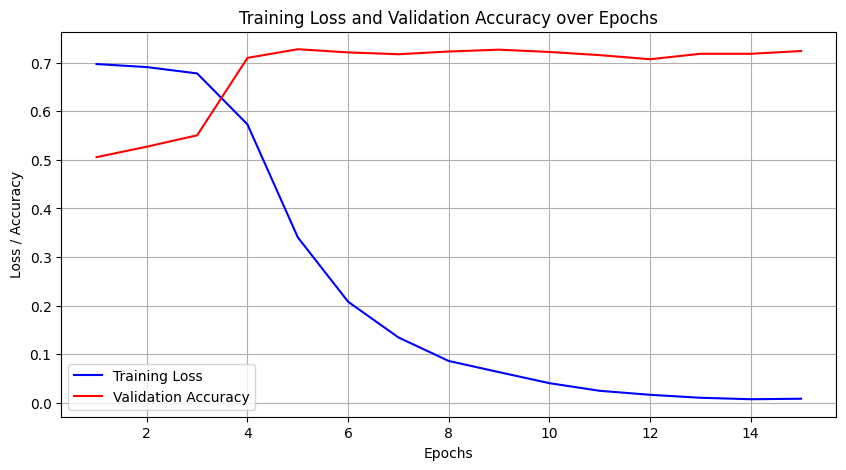

In [18]:
plot_loss_accuracy(losses, accuracies)

In [19]:
mean_tst_accuracy = validate(model, tst_dataloader)

Accuracy: 0.7392


## Max Pool Model

In [20]:
model = RNNModel(
    embedding_dim=350,
    hidden_size=128,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,
    freeze_embeddings=False,  # Set to False to make embeddings trainable
    bidirectional=False,
    num_layers=1,
)

In [21]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="max_pooling"
)

Epoch   1/100, Loss: 0.6941, Accuracy: 0.5103
Model saved.
Epoch   2/100, Loss: 0.6905, Accuracy: 0.5075
Epoch   3/100, Loss: 0.6673, Accuracy: 0.6660
Model saved.
Epoch   4/100, Loss: 0.4907, Accuracy: 0.7205
Model saved.
Epoch   5/100, Loss: 0.3035, Accuracy: 0.7195
Epoch   6/100, Loss: 0.2003, Accuracy: 0.7242
Model saved.
Epoch   7/100, Loss: 0.1324, Accuracy: 0.7270
Model saved.
Epoch   8/100, Loss: 0.0892, Accuracy: 0.7101
Epoch   9/100, Loss: 0.0664, Accuracy: 0.7026
Epoch  10/100, Loss: 0.0505, Accuracy: 0.7054
Epoch  11/100, Loss: 0.0318, Accuracy: 0.7045
Epoch  12/100, Loss: 0.0210, Accuracy: 0.6942
Epoch  13/100, Loss: 0.0157, Accuracy: 0.7064
Epoch  14/100, Loss: 0.0134, Accuracy: 0.7036
Epoch  15/100, Loss: 0.0113, Accuracy: 0.7026
Epoch  16/100, Loss: 0.0104, Accuracy: 0.7064
Epoch  17/100, Loss: 0.0121, Accuracy: 0.7054
Early stopping triggered after 17 epochs.
Training ended, loading best model...
Model loaded.


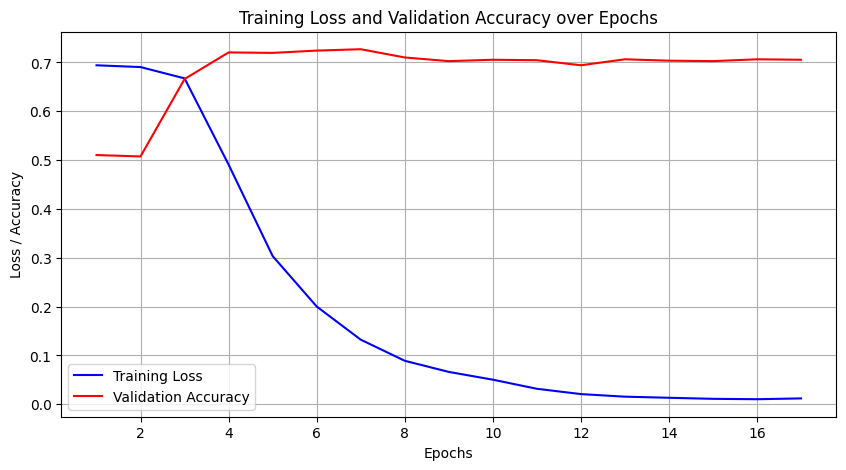

In [22]:
plot_loss_accuracy(losses, accuracies)

In [23]:
max_tst_accuracy = validate(model, tst_dataloader)

Accuracy: 0.7505


## Mean Max Pool Model

In [24]:
model = RNNModel(
    embedding_dim=350,
    hidden_size=128,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,
    freeze_embeddings=False,  # Set to False to make embeddings trainable
    bidirectional=False,
    num_layers=1,
)

In [25]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="mean_max"
)

Epoch   1/100, Loss: 0.6956, Accuracy: 0.5141
Model saved.
Epoch   2/100, Loss: 0.6897, Accuracy: 0.5094
Epoch   3/100, Loss: 0.6619, Accuracy: 0.6614
Model saved.
Epoch   4/100, Loss: 0.4640, Accuracy: 0.7383
Model saved.
Epoch   5/100, Loss: 0.2818, Accuracy: 0.7205
Epoch   6/100, Loss: 0.1880, Accuracy: 0.7026
Epoch   7/100, Loss: 0.1304, Accuracy: 0.7139
Epoch   8/100, Loss: 0.0910, Accuracy: 0.7045
Epoch   9/100, Loss: 0.0681, Accuracy: 0.7101
Epoch  10/100, Loss: 0.0502, Accuracy: 0.7101
Epoch  11/100, Loss: 0.0373, Accuracy: 0.6951
Epoch  12/100, Loss: 0.0250, Accuracy: 0.7064
Epoch  13/100, Loss: 0.0258, Accuracy: 0.7045
Epoch  14/100, Loss: 0.0301, Accuracy: 0.6904
Early stopping triggered after 14 epochs.
Training ended, loading best model...
Model loaded.


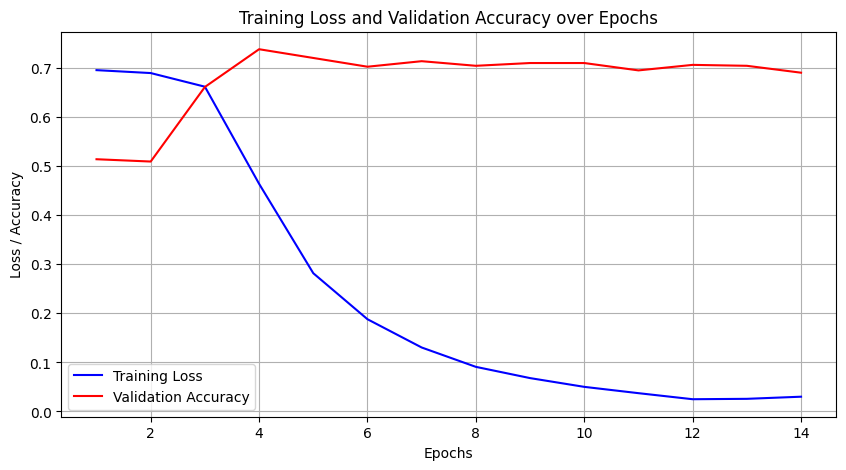

In [26]:
plot_loss_accuracy(losses, accuracies)

In [27]:
mean_max_tst_accuracy = validate(model, tst_dataloader)

Accuracy: 0.7477


## Attention Model

In [28]:
model = RNNModel(
    embedding_dim=350,
    hidden_size=128,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,
    freeze_embeddings=False,  # Set to False to make embeddings trainable
    bidirectional=False,
    num_layers=1,
)

In [29]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="attention"
)

Epoch   1/100, Loss: 0.6966, Accuracy: 0.5235
Model saved.
Epoch   2/100, Loss: 0.6895, Accuracy: 0.5319
Model saved.
Epoch   3/100, Loss: 0.6178, Accuracy: 0.7111
Model saved.
Epoch   4/100, Loss: 0.3840, Accuracy: 0.7129
Model saved.
Epoch   5/100, Loss: 0.2458, Accuracy: 0.7139
Model saved.
Epoch   6/100, Loss: 0.1632, Accuracy: 0.7186
Model saved.
Epoch   7/100, Loss: 0.1152, Accuracy: 0.7101
Epoch   8/100, Loss: 0.0831, Accuracy: 0.7176
Epoch   9/100, Loss: 0.0611, Accuracy: 0.7111
Epoch  10/100, Loss: 0.0494, Accuracy: 0.6970
Epoch  11/100, Loss: 0.0372, Accuracy: 0.7026
Epoch  12/100, Loss: 0.0308, Accuracy: 0.7092
Epoch  13/100, Loss: 0.0255, Accuracy: 0.7045
Epoch  14/100, Loss: 0.0213, Accuracy: 0.7083
Epoch  15/100, Loss: 0.0149, Accuracy: 0.7101
Epoch  16/100, Loss: 0.0101, Accuracy: 0.7101
Early stopping triggered after 16 epochs.
Training ended, loading best model...
Model loaded.


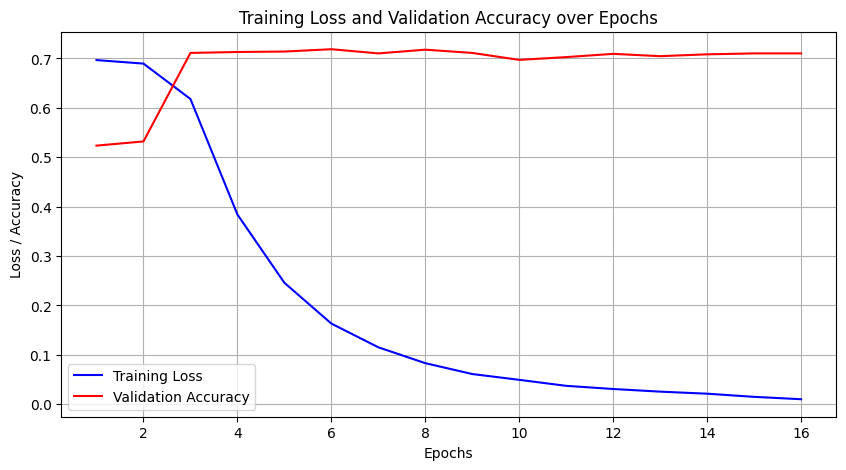

In [30]:
plot_loss_accuracy(losses, accuracies)

In [31]:
attn_tst_accuracy = validate(model, tst_dataloader)

Accuracy: 0.7298


# Results

In [32]:
print(f"Default RNN Test Accuracy:      {rnn_tst_accuracy:.4f}")
print(f"Last State Test Accuracy:       {last_tst_accuracy:.4f}")
print(f"Mean Pool Test Accuracy:        {mean_tst_accuracy:.4f}")
print(f"Max Pool Test Accuracy:         {max_tst_accuracy:.4f}")
print(f"Mean Max Pool Test Accuracy:    {mean_max_tst_accuracy:.4f}")
print(f"Attention Test Accuracy:        {attn_tst_accuracy:.4f}")

Default RNN Test Accuracy:      0.7514
Last State Test Accuracy:       0.7514
Mean Pool Test Accuracy:        0.7392
Max Pool Test Accuracy:         0.7505
Mean Max Pool Test Accuracy:    0.7477
Attention Test Accuracy:        0.7298


From the above results, it is evident that implementing the OOV mitigation solution from Part 1 has improved the accuracy of the models

| Model Type | Part 3.1 Accuracy | Part 3.1 Accuracy |
| --- | --- | --- |
| Default LSTM | 0.7355 | 0.7514 |
| Last State | 0.7186 | 0.7514 |
| Mean Pooling | 0.7186 | 0.7392 |
| Max Pooling | 0.7298 | 0.7505 |
| Mean Max Pooling | 0.7205 | 0.7477 |
| Attention | 0.7167 | 0.7298 |